In [ ]:
# Source: https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

In [172]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
from pyspark.mllib.stat import Statistics
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, LinearRegressionModel
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator

## Initialize the spark environment

In [2]:
# Initialize the spark environment (takes ~ 1min)
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

## Preparation of data 

In [80]:
# Get data from S3 bucket
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'jh6rg/camera_dataset.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)  # Put to the bucket
df = sqlc.createDataFrame(pd.read_csv(data_location)) # Pull everything into the memory
df  # (1038, 13)

DataFrame[Model: string, Release date: bigint, Max resolution: double, Low resolution: double, Effective pixels: double, Zoom wide (W): double, Zoom tele (T): double, Normal focus range: double, Macro focus range: double, Storage included: double, Weight (inc. batteries): double, Dimensions: double, Price: double]

In [81]:
# Rename some columns
("Release date","datedf = df.withColumnRenamed").withColumnRenamed("Max resolution", "Max_Resolution").\
withColumnRenamed("Low resolution", "Low_Resolution").\
withColumnRenamed("Effective pixels", "Effective_pixels").withColumnRenamed("Zoom wide (W)", "Zoom_wide").\
withColumnRenamed("Zoom tele (T)", "Zoom_tele").withColumnRenamed("Normal focus range", "Normal_focus_range").\
withColumnRenamed("Macro focus range", "Macro_focus_range").withColumnRenamed("Storage included", 'Storage_included').\
withColumnRenamed("Weight (inc. batteries)", "Weight")

In [82]:
df   # Check column names

DataFrame[Model: string, date: bigint, Max_Resolution: double, Low_Resolution: double, Effective_pixels: double, Zoom_wide: double, Zoom_tele: double, Normal_focus_range: double, Macro_focus_range: double, Storage_included: double, Weight: double, Dimensions: double, Price: double]

### Get into the parquet

In [3]:
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/Spark19SpDS6003-001/jh6rg/parquet3/test-parquet'
df.write.parquet(parquetPath)

In [11]:
# prep list of files to transfer
files = [f for f in listdir(parquetPath) if isfile(join(parquetPath, f))]

s3 = boto3.resource('s3')
for f in files:
    #print('copying {} to {}'.format(parquetPath+'/'+f,"sample_data/"+f))
    s3.Bucket(bucket).upload_file(parquetPath+'/'+f, "sample_data/pqt/"+f)

### Write from parquet

In [12]:
# Model describes the datatype for each column which can be dropped
df = sqlc.read.parquet(parquetPath)
df = df.drop(df.Model).dropna()

In [13]:
print((df.count(), len(df.columns)))   # Check dataset's shape (1036, 13)

(1036, 12)


## MLlib Basics

In [14]:
# Check the first five rows
df.take(5)

[Row(date=1997, Max_Resolution=1024.0, Low_Resolution=640.0, Effective_pixels=0.0, Zoom_wide=38.0, Zoom_tele=114.0, Normal_focus_range=70.0, Macro_focus_range=40.0, Storage_included=4.0, Weight=420.0, Dimensions=95.0, Price=179.0),
 Row(date=1998, Max_Resolution=1280.0, Low_Resolution=640.0, Effective_pixels=1.0, Zoom_wide=38.0, Zoom_tele=114.0, Normal_focus_range=50.0, Macro_focus_range=0.0, Storage_included=4.0, Weight=420.0, Dimensions=158.0, Price=179.0),
 Row(date=2000, Max_Resolution=640.0, Low_Resolution=0.0, Effective_pixels=0.0, Zoom_wide=45.0, Zoom_tele=45.0, Normal_focus_range=0.0, Macro_focus_range=0.0, Storage_included=2.0, Weight=0.0, Dimensions=0.0, Price=179.0),
 Row(date=1999, Max_Resolution=1152.0, Low_Resolution=640.0, Effective_pixels=0.0, Zoom_wide=35.0, Zoom_tele=35.0, Normal_focus_range=0.0, Macro_focus_range=0.0, Storage_included=4.0, Weight=0.0, Dimensions=0.0, Price=269.0),
 Row(date=1999, Max_Resolution=1152.0, Low_Resolution=640.0, Effective_pixels=0.0, Zoom

In [50]:
print("Pearson's r(Low resolution,Max resolution) = {}".format(df.corr("Low_Resolution","Max_Resolution")))
print("Pearson's r(date,Max resolution) = {}".format(df.corr("date","Max_Resolution")))
print("Pearson's r(Effective pixels,Max resolution) = {}".format(df.corr("Effective_pixels", "Max_Resolution")))
print("Pearson's r(Normal focus range,Min resolution) = {}".format(df.corr("Normal_focus_range", "Low_Resolution")))
print("Pearson's r(Dimensions,Weight) = {}".format(df.corr("Dimensions","Weight")))

Pearson's r(Low resolution,Max resolution) = 0.8427902099798614
Pearson's r(date,Max resolution) = 0.7882343813633058
Pearson's r(Effective pixels,Max resolution) = 0.9538458570187706
Pearson's r(Normal focus range,Min resolution) = -0.12543611622804537
Pearson's r(Dimensions,Weight) = 0.6778848089757021


In [16]:
print("Pearson's r(Date,Price) = {}".format(df.corr("date", "Price")))
print("Pearson's r(Max Resolution,Price) = {}".format(df.corr("Max_Resolution", "Price")))
print("Pearson's r(Low Resolution,Price) = {}".format(df.corr("Low_Resolution", "Price")))
print("Pearson's r(Zoom wide,Price) = {}".format(df.corr("Zoom_wide", "Price")))
print("Pearson's r(Normal focus range,Price) = {}".format(df.corr("Normal_focus_range", "Price")))
print("Pearson's r(Macro focus range,Price) = {}".format(df.corr("Macro_focus_range", "Price")))
print("Pearson's r(Effective pixels,Price) = {}".format(df.corr("Effective_pixels", "Price")))
print("Pearson's r(Dimension,Price) = {}".format(df.corr("Dimensions", "Price")))

Pearson's r(Date,Price) = -0.022522217044592785
Pearson's r(Max Resolution,Price) = 0.18420092652935718
Pearson's r(Low Resolution,Price) = 0.15420406063216538
Pearson's r(Zoom wide,Price) = -0.4591033999208599
Pearson's r(Normal focus range,Price) = -0.27385393615399717
Pearson's r(Macro focus range,Price) = -0.12757671236241522
Pearson's r(Effective pixels,Price) = 0.190284007565066
Pearson's r(Dimension,Price) = 0.2642561651698723


In [66]:
col_names = df.columns
features = df.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.788234,0.750016,0.790263,-0.071612,0.193020,-0.074887,-0.253491,0.213093,-0.259681,-0.248877,-0.022522
1,0.788234,1.000000,0.842790,0.953846,-0.373958,0.069377,-0.200449,-0.347301,0.166222,0.106678,-0.000057,0.184201
2,0.750016,0.842790,1.000000,0.820322,-0.206477,0.154785,-0.125436,-0.315787,0.156652,-0.044927,-0.105585,0.154204
3,0.790263,0.953846,0.820322,1.000000,-0.328514,0.084644,-0.193252,-0.321930,0.157844,0.078198,-0.004077,0.190284
4,-0.071612,-0.373958,-0.206477,-0.328514,1.000000,0.364647,0.538510,0.293331,0.150968,-0.698782,-0.486542,-0.459103
5,0.193020,0.069377,0.154785,0.084644,0.364647,1.000000,0.167641,-0.074554,0.114075,-0.065904,-0.118171,-0.189480
6,-0.074887,-0.200449,-0.125436,-0.193252,0.538510,0.167641,1.000000,0.397832,0.159605,-0.393359,-0.237108,-0.273854
7,-0.253491,-0.347301,-0.315787,-0.321930,0.293331,-0.074554,0.397832,1.000000,-0.043769,-0.210554,-0.090336,-0.127577
8,0.213093,0.166222,0.156652,0.157844,0.150968,0.114075,0.159605,-0.043769,1.000000,-0.155568,-0.114280,-0.103046
9,-0.259681,0.106678,-0.044927,0.078198,-0.698782,-0.065904,-0.393359,-0.210554,-0.155568,1.000000,0.677885,0.464760


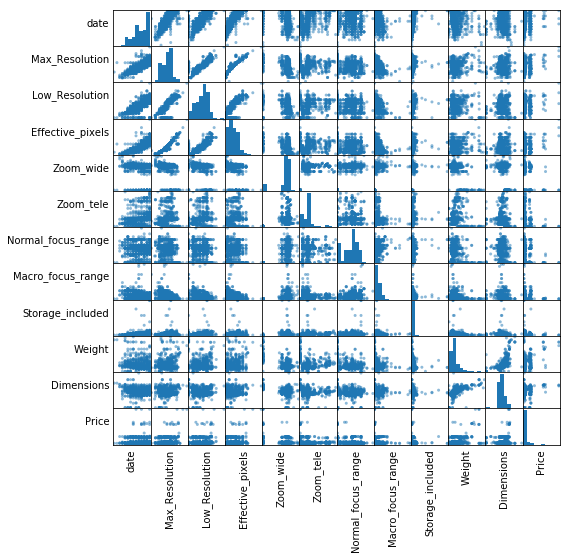

In [17]:
# Correlation analysis
numeric_data = df.select(df.columns).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## MLlib based analysis

### Linear Regression

In [ ]:
# Based on the correlation analsyis, Max_Resolution has strong relationship with Low_Resolution and Effective pixels,
# therefore the two variables are remove in order to avoid multicollinearity.

In [77]:
df = df.drop(df.Low_Resolution).drop(df.Effective_pixels)

In [138]:
stages = []
df = df.withColumnRenamed("Price", "label")
assemblerInputs = df.columns[:-1]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [139]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df3 = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df3 = df3.select(selectedCols)

In [140]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df3.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 843, test set N = 193


In [141]:
lr = LinearRegression()
lrModel = lr.fit(trainingDF)

In [142]:
predictionsAndLabelsDF = lrModel.transform(testDF)

[Row(label=7999.0, features=SparseVector(9, {0: 2004.0, 1: 4992.0, 7: 1565.0, 8: 156.0}), prediction=2574.196454908218), Row(label=4999.0, features=DenseVector([2001.0, 2048.0, 35.0, 105.0, 24.0, 1.0, 8.0, 320.0, 142.0]), prediction=309.0750857805906), Row(label=4999.0, features=SparseVector(9, {0: 2007.0, 1: 4256.0, 7: 1300.0, 8: 160.0}), prediction=2131.143062780773), Row(label=4499.0, features=SparseVector(9, {0: 2004.0, 1: 3008.0, 7: 620.0, 8: 142.0}), prediction=1174.9207222138639), Row(label=1699.0, features=SparseVector(9, {0: 2004.0, 1: 3264.0, 7: 624.0, 8: 147.0}), prediction=1188.83483047475)]


In [143]:
eval = RegressionEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation - one of:
                       rmse - root mean squared error (default)
                       mse - mean squared error
                       r2 - r^2 metric
                       mae - mean absolute error. (default: rmse)
predictionCol: prediction column name. (default: prediction)


In [144]:
eval.setMetricName("rmse").evaluate(predictionsAndLabelsDF)

774.5273680934473

In [145]:
eval.setMetricName("r2").evaluate(predictionsAndLabelsDF)

0.21088048996240438

It seems that linear regression does not fit the data

### Logistic Regression

In [152]:
df.groupBy().avg('label').collect()

[Row(avg(label)=457.9218146718147)]

In [154]:
# Create a new feature "isExpensive" indicating whether Price(label) is above average
df = df.withColumn('isExpensive',when(df.label > 458,1).otherwise(0)).drop(df.label)
df

DataFrame[date: bigint, Max_Resolution: double, Zoom_wide: double, Zoom_tele: double, Normal_focus_range: double, Macro_focus_range: double, Storage_included: double, Weight: double, Dimensions: double, isExpensive: int]

In [161]:
stages = []
label_stringIdx = StringIndexer(inputCol = 'isExpensive', outputCol = 'label')
stages += [label_stringIdx]
assemblerInputs = df.columns[:-3]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [168]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df3 = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df3 = df3.select(selectedCols)

In [169]:
trainDF, testDF = df3.randomSplit([0.7, 0.3], seed = 2019)
print ('training set N = {}, test set N = {}'.format(train_df.count(),test_df.count()))

training set N = 721, test set N = 315


In [170]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(trainDF)

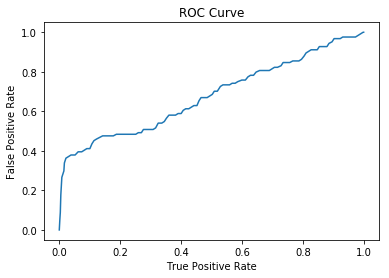

In [171]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [173]:
predictions = lrModel.transform(test_df)
evaluator = BinaryClassificationEvaluator()
print('Test AUC', evaluator.evaluate(predictions))

Test AUC 0.7359670781893008
